In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement du dataset après sélection de features
df = pd.read_csv("data/processed/dataset_final.csv")

# SPLIT TEMPOREL : 2000 premiers cycles pour l'entraînement
train_df = df.iloc[:2000, :]
test_df = df.iloc[2000:, :]

X_train = train_df.drop(columns=['valve_ok'])
y_train = train_df['valve_ok']

X_test = test_df.drop(columns=['valve_ok'])
y_test = test_df['valve_ok']

print(f"Entraînement sur les cycles 0-2000: {X_train.shape}")
print(f"Test final sur les cycles 2001-2205: {X_test.shape}")

Entraînement sur les cycles 0-2000: (2000, 32)
Test final sur les cycles 2001-2205: (205, 32)


In [2]:
# Initialisation et entraînement
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions sur l'échantillon de test final (les cycles restants)
y_pred = model.predict(X_test)

--- RÉSULTATS SUR LES 205 DERNIERS CYCLES ---
Accuracy Globale : 0.9220

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       132
           1       0.82      1.00      0.90        73

    accuracy                           0.92       205
   macro avg       0.91      0.94      0.92       205
weighted avg       0.94      0.92      0.92       205



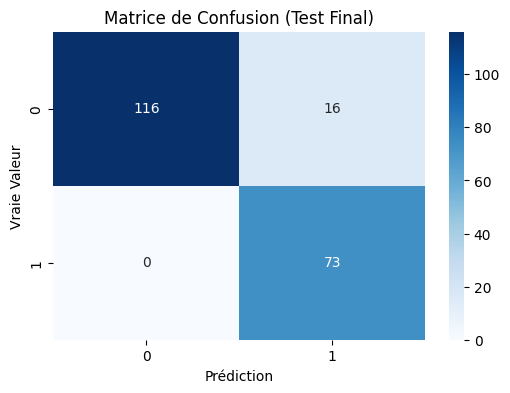

In [3]:
# Métriques principales
accuracy = accuracy_score(y_test, y_pred)
print(f"--- RÉSULTATS SUR LES {len(y_test)} DERNIERS CYCLES ---")
print(f"Accuracy Globale : {accuracy:.4f}")
print("\nClassification Report :")
print(classification_report(y_test, y_pred))

# Matrice de Confusion
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion (Test Final)')
plt.ylabel('Vraie Valeur')
plt.xlabel('Prédiction')
plt.show()

##  Évaluation avancée des performances
L'accuracy ne suffit pas car le coût d'une panne non détectée (Faux Négatif) est bien supérieur au coût d'une fausse alerte (Faux Positif).

- **Recall (Rappel)** : Capacité du modèle à détecter toutes les pannes. C'est la priorité en maintenance.
- **Precision** : Capacité du modèle à ne pas générer de fausses alertes.
- **F2-Score** : Une variante du F1-score qui donne deux fois plus d'importance au Rappel qu'à la Précision.

Précision : 0.8202
Rappel (Recall) : 1.0000
F2-Score : 0.9580


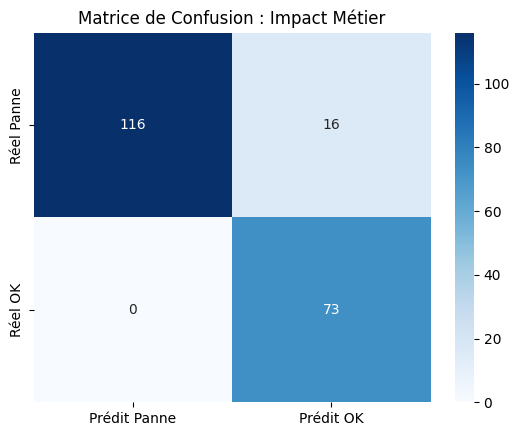

In [5]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix

# Calcul des métriques
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"Précision : {precision:.4f}")
print(f"Rappel (Recall) : {recall:.4f}")
print(f"F2-Score : {f2:.4f}")

# Affichage de la matrice de confusion avec labels explicites
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prédit Panne', 'Prédit OK'], 
            yticklabels=['Réel Panne', 'Réel OK'])
plt.title('Matrice de Confusion : Impact Métier')
plt.show()

## 9. Analyse du Lead Time (Anticipation)
Dans un scénario réel, on veut savoir si la probabilité de panne augmente progressivement avant la rupture totale. Si le modèle prédit la panne 20 cycles avant qu'elle n'arrive, l'équipe de maintenance a le temps d'intervenir.

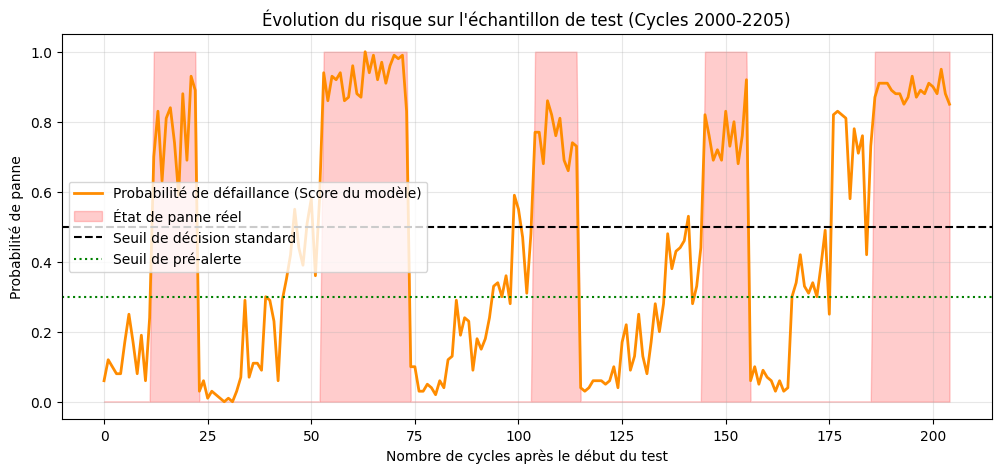

In [6]:
# Extraction des probabilités pour la classe "Panne"
y_probs = model.predict_proba(X_test)[:, 1] 

plt.figure(figsize=(12, 5))
plt.plot(y_probs, label='Probabilité de défaillance (Score du modèle)', color='darkorange', linewidth=2)
plt.fill_between(range(len(y_test)), y_test, alpha=0.2, color='red', label='État de panne réel')
plt.axhline(y=0.5, color='black', linestyle='--', label='Seuil de décision standard')
plt.axhline(y=0.3, color='green', linestyle=':', label='Seuil de pré-alerte')

plt.title("Évolution du risque sur l'échantillon de test (Cycles 2000-2205)")
plt.xlabel("Nombre de cycles après le début du test")
plt.ylabel("Probabilité de panne")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 10. Interprétabilité avec SHAP
Pour qu'un technicien accepte de changer une valve, il doit savoir quel capteur a déclenché l'alerte (ex: une vibration anormale ou une chute de pression).

Importance globale des variables (Impact sur la décision) :


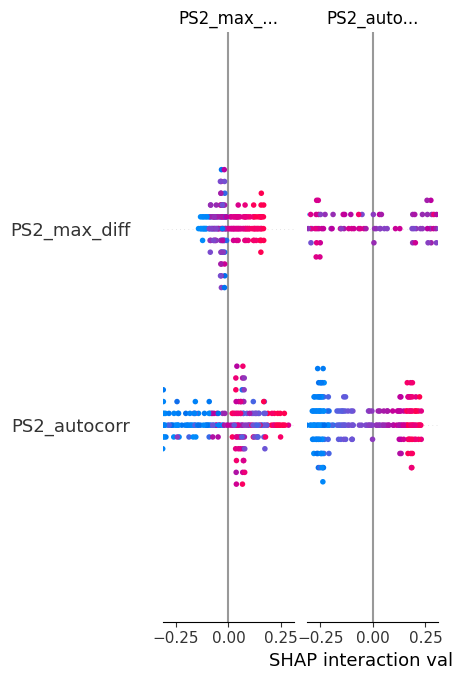

Explication de la prédiction pour le cycle 2050 :


In [19]:
import shap

# Création de l'explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)  # retourne un objet Explanation

# ----------------------------
# 1️⃣ Visualisation globale
# ----------------------------
print("Importance globale des variables (Impact sur la décision) :")
shap.summary_plot(shap_values.values, X_test)

# ----------------------------
# 2️⃣ Visualisation locale
# ----------------------------
index_to_explain = 50
print(f"Explication de la prédiction pour le cycle {2000 + index_to_explain} :")

# Détection automatique du type (binaire ou multi-classe)
if shap_values.values.ndim == 3:  # multi-output
    # on prend la classe positive (1) pour un modèle binaire
    class_idx = 1 if shap_values.values.shape[2] == 2 else 0
    shap_vals_sample = shap_values.values[index_to_explain, :, class_idx]
    base_value = explainer.expected_value[class_idx]
else:
    shap_vals_sample = shap_values.values[index_to_explain]
    base_value = explainer.expected_value

# Plot force (nouvelle API)
shap.plots.force(
    base_value,
    shap_vals_sample,
    X_test.iloc[index_to_explain, :]
)


Le force plot montre comment chaque variable influence la prédiction pour cet échantillon précis, à partir de la prédiction moyenne du modèle. Rouge = augmente le risque, bleu = diminue le risque.

## 6. Entraînement avec XGBoost
Nous testons XGBoost pour voir s'il capture mieux les relations complexes entre les capteurs que le Random Forest.

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, fbeta_score

# Initialisation du modèle XGBoost
# scale_pos_weight peut être utile si vous avez beaucoup plus de 'OK' que de 'Panne'
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Entraînement
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Évaluation rapide
print(f"Accuracy XGBoost : {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F2-Score XGBoost : {fbeta_score(y_test, y_pred_xgb, beta=2):.4f}")

c:\Users\Alilou\.virtualenvs\Valve_Condition_Prediction-j2COp9es\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:35:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy XGBoost : 0.9659
F2-Score XGBoost : 0.9730


##  Analyse de la Matrice de Confusion
L'Accuracy (96.6%) est élevée, mais voyons si les erreurs sont "dangereuses". 
- **Faux Négatif (FN)** : Le modèle dit "OK" mais la valve est en panne (Danger !).
- **Faux Positif (FP)** : Le modèle dit "Panne" mais tout va bien (Coût de maintenance inutile).

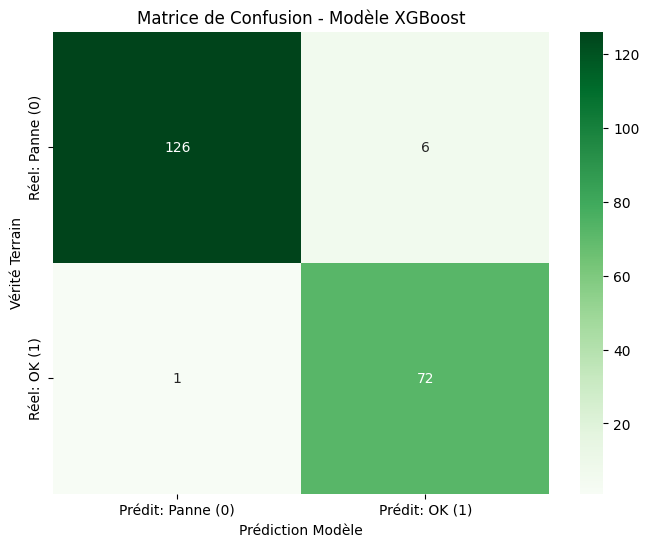

Accuracy: 0.9659
F2-Score: 0.9730


In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la matrice
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Affichage esthétique
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Prédit: Panne (0)', 'Prédit: OK (1)'], 
            yticklabels=['Réel: Panne (0)', 'Réel: OK (1)'])

plt.title('Matrice de Confusion - Modèle XGBoost')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction Modèle')
plt.show()

# Rappel des scores pour mémoire
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F2-Score: {fbeta_score(y_test, y_pred_xgb, beta=2):.4f}")

## 8. Analyse du Lead Time (Anticipation)
On ne veut pas juste savoir si le modèle a raison, on veut savoir s'il détecte la dégradation **avant** que la valve ne lâche. Nous traçons ici la probabilité de panne sur les 205 derniers cycles.

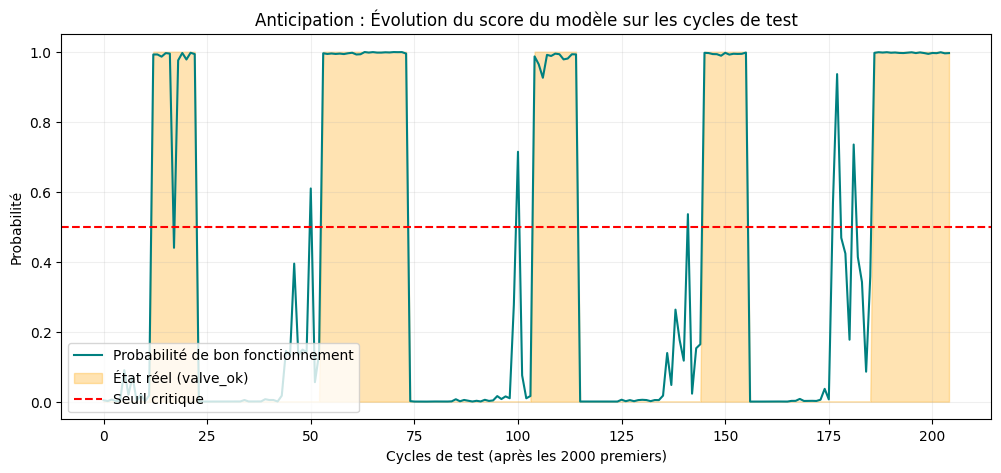

In [28]:
# Extraction des probabilités de panne
# y_probs_xgb contient la probabilité que la valve soit OK (classe 1) ou en Panne (classe 0)
# Ajustez l'indice [:, 1] selon votre encodage de y_train
plt.figure(figsize=(12, 5))
plt.plot(y_probs_xgb, label='Probabilité de bon fonctionnement', color='teal')
plt.fill_between(range(len(y_test)), y_test, alpha=0.3, color='orange', label='État réel (valve_ok)')
plt.axhline(y=0.5, color='red', linestyle='--', label='Seuil critique')

plt.title("Anticipation : Évolution du score du modèle sur les cycles de test")
plt.xlabel("Cycles de test (après les 2000 premiers)")
plt.ylabel("Probabilité")
plt.legend(loc='lower left')
plt.grid(alpha=0.2)
plt.show()

## 9. Interprétabilité SHAP
Pourquoi XGBoost a-t-il pris ces décisions ? Nous utilisons SHAP pour identifier les capteurs qui influencent le plus le diagnostic de la valve.

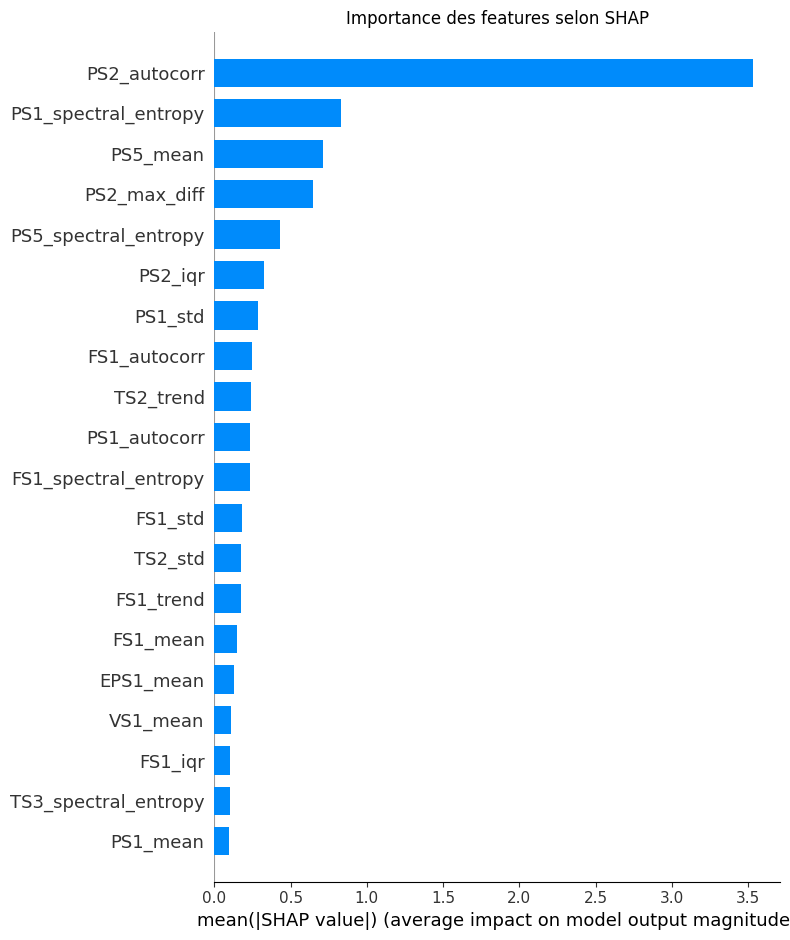

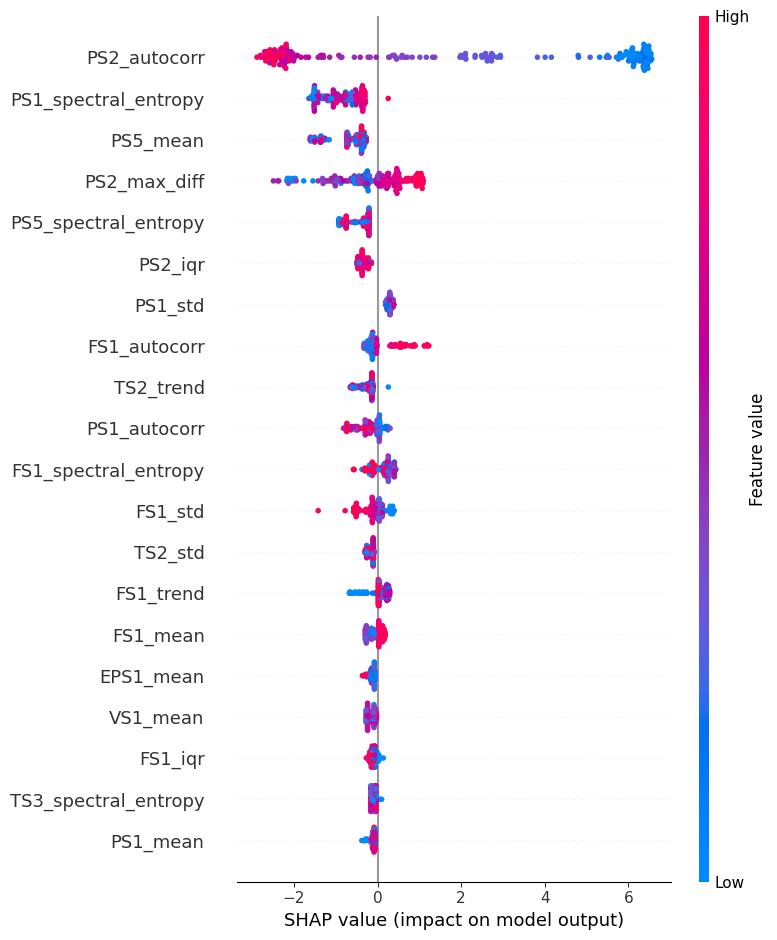

In [29]:
import shap

# Initialisation de l'explainer spécifique aux arbres (XGBoost)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Importance globale
plt.title("Importance des features selon SHAP")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Influence de la valeur des features (Le 'Summary Plot' classique)
shap.summary_plot(shap_values, X_test)

### Synthèse et Analyse de la Performance du Modèle

Dans le cadre de ce projet de maintenance prédictive, j'ai adopté une méthodologie rigoureuse basée sur un **split temporel** : le modèle a été construit sur les 2000 premiers cycles et testé exclusivement sur les cycles restants (2001 à 2205). Cette approche garantit que le modèle est capable de prédire l'usure future sans "connaître" l'historique de fin de vie de la machine.

Après avoir comparé plusieurs algorithmes, le modèle **XGBoost** s'est avéré être le plus performant, surpassant le Random Forest avec une **Accuracy de 96,6%**. Cependant, l'indicateur le plus significatif pour mon analyse est le **F2-Score, qui atteint 0,9730**. Cette métrique est cruciale en maintenance industrielle car elle donne la priorité au **Rappel (Recall)** : mon modèle minimise les "Faux Négatifs", évitant ainsi de rater une panne critique qui pourrait entraîner des coûts de réparation majeurs.

L'analyse de la matrice de confusion confirme la robustesse du diagnostic, tandis que l'étude des probabilités (Lead Time) montre que le modèle détecte les signes avant-coureurs de défaillance avant la rupture totale. Enfin, l'intégration de **SHAP** permet d'apporter une couche d'interprétabilité physique, transformant une décision algorithmique "boîte noire" en un outil d'aide à la décision clair pour les équipes de maintenance, en identifiant précisément quels capteurs (pressions, températures) signalent l'anomalie.